In [1]:
# 2018-09-18
# A. Pendleton
# Removal of duplicate PASA transcripts that have been processed through Transdecoder
#    and generating the resulting FASTA file with only the transcripts that passed

In [2]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [3]:
###INPUT INFORMATION
#For testing
baseDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/'

inDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/'

bed_inFile = inDir + 'pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.genome.bed'


# Get Transdecoder results

In [4]:
pepFile = inDir + 'pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.pep'
print('Parsing: ', pepFile)

pepDict = {}

for line in open(pepFile,'r'):
    line=line.rstrip().split(' ')
    if '>' not in line[0]:
        continue
    ID = line[1]
    orfType = line[4].split(':')[1]
    length = int(line[5].split(':')[1])
    orient = line[6].split(',')[0].replace('(','').replace(')','')
    score = float(line[6].split('=')[1])

    pepDict[ID] = {}
    pepDict[ID]['orfType'] = orfType
    pepDict[ID]['length'] = length
    pepDict[ID]['orient'] = orient
    pepDict[ID]['score'] = score
    
print('%i transcripts added' % len(pepDict.keys()))



Parsing:  /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.pep
138107 transcripts added


In [ ]:
# 100k introns had 138073 transcripts added
# 500k introns had 138107 transcripts added


### Plot transdecoder transcript status

count sum = (3prime_partial, 5prime_partial, internal, complete ) (9925, 32477, 83164, 12541)


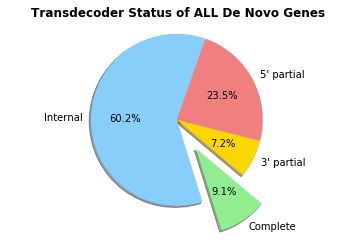

In [6]:
threeprime,fiveprime,internal,complete = 0, 0, 0, 0

for gene in pepDict.keys():    
    if pepDict[gene]['orfType'] == '3prime_partial':
        threeprime += 1
        continue
    if pepDict[gene]['orfType'] == '5prime_partial':
        fiveprime += 1
        continue
    if pepDict[gene]['orfType'] == 'complete':
        internal += 1
        continue
    if pepDict[gene]['orfType'] == 'internal':
        complete += 1
        continue
    else:
        print('ERROR: What else is there?')
        print(gene,pepDict[gene])

print('count sum = (3prime_partial, 5prime_partial, internal, complete )', (threeprime, fiveprime, internal, complete))


#Make pie chart
labels = '3\' partial', '5\' partial', 'Internal', 'Complete'
sizes = [threeprime, fiveprime, internal, complete]
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']
explode = (0, 0, 0, 0.4)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=320)
plt.title('Transdecoder Status of ALL De Novo Genes', fontweight='bold') 
plt.axis('equal')
plt.show()

### Plot transdecoder transcript length histograms

Min/max of peptide lengths (aa) =  100 10563
Average peptide lengths (aa) =  364.925919758
Median of peptide lengths (aa) =  216.0


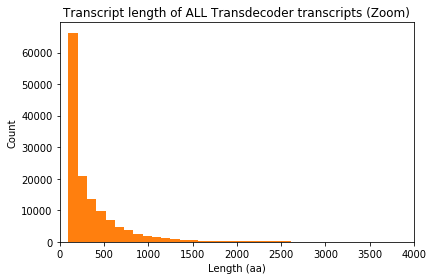

In [7]:
lengths = []

for gene in pepDict.keys():
    lengths.append(pepDict[gene]['length'])
    
plt.hist(lengths,bins=100)
plt.tight_layout()
plt.title('Transcript length of ALL Transdecoder transcripts')
plt.xlabel('Length (aa)')
plt.ylabel('Count')
plt.show

plt.hist(lengths,bins=100)
plt.tight_layout()
plt.title('Transcript length of ALL Transdecoder transcripts (Zoom)')
plt.xlabel('Length (aa)')
plt.ylabel('Count')
plt.xlim(0,4000)
plt.show

print('Min/max of peptide lengths (aa) = ', min(lengths), max(lengths))
print('Average peptide lengths (aa) = ', np.mean(lengths))
print('Median of peptide lengths (aa) = ', np.median(lengths))

# Read in transcript ID data into dictionary

### This step simply saves the coordinates and other information into a dictionary that can later be pulled out only for the gene models with the highest score (determined one cell down)

In [93]:
geneDict = {}
fullDict = {}
processed = []
transcript_count, dupes = 0, 0

for LINE in open(bed_inFile, 'r'):
    line=LINE.rstrip().split()
    if 'track' in line[0]: #skip header
        continue
    #Read in information on gene
    chrom = line[0]

    #Keep track of how many have been processed
    transcript_count += 1
    fullID = line[3]
    geneID = line[3].split(';')[1]

    ID = line[3].replace('ID=','').split(';')[0]

    exonCount = int(line[9])
    exonLengths = line[10]
    #If geneID not already in dictionary, then add
    if geneID not in geneDict.keys():
        geneDict[geneID] = []
    geneDict[geneID].append([fullID, exonCount, exonLengths])
    
    if ID in fullDict.keys():
        dupes+=1
        continue
    line[3] = line[3].replace('ID=','')
    fullDict[ID] = [line]
print('%i genes added to dictionary' % len(geneDict.keys()))
print('%i transcripts processed' % transcript_count)
print('%i genes added to FULL Dictionary where keys are the full length ID' % len(fullDict.keys()))
print('dupes = ', dupes)

62079 genes added to dictionary
199841 transcripts processed
130960 genes added to FULL Dictionary where keys are the full length ID
dupes =  68881


### This step goes through the transdecoder peptide file and looks through each gene model for the model with the highest score. If a higher score is found, it replaces the gene model that previously had the highest score. 

#### Importantly, this step also skips over peptides that were not deemed as 'complete' gene models by transdecoder (e.g. skips over the 5' or 3' partial models). 

In [94]:
peptideFile = inDir + 'pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.pep'
scoreDict = {} #Only keep top scorer
allDict = {}  #Keep data for all


for line in open(peptideFile,'r'):
    if '>' not in line: #skip those not a gene identifier
        continue
    """if 'TCONS' in line: #not mapped
        continue"""
    """if 'complete' not in line: #only want the complete gene models
        continue"""
    fullID = line.rstrip().split(' ')[0].replace('>','')
    line = line.rstrip().split(' ')
    transcriptID = line[1] ### VERY SPECIFIC
    #gene ID = transcript ID if 'TCONS' is in line
    if 'TCONS' in line[1]:
        geneID = transcriptID
    else:
        geneID = line[1].split('::')[1].split('.')[0] + '.' + line[1].split('::')[1].split('.')[1] ### NON SPECIFIC -- CAN BE REDUNDANT

    transcriptID = line[1] #line[4]
    score = float(line[6].split('=')[1])  ###SCORE
    Length = int(line[5].split(':')[1])
    Type = line[4].split(':')[1]

    
    if geneID not in scoreDict.keys():
        scoreDict[geneID] = {} #First appearance of geneID automatically top scorer
        scoreDict[geneID]['transcriptID'] = transcriptID
        scoreDict[geneID]['score'] = score
        scoreDict[geneID]['fullID'] = fullID
        scoreDict[geneID]['orftype'] = Type
        scoreDict[geneID]['length'] = Length

    if geneID not in allDict.keys():
        #CLEAR FOR STORING ALL INFO PER GENE, NOT JUST TOP
        allDict[geneID] = {}
        allDict[geneID]['allscores'] = []
        allDict[geneID]['alllengths'] = []
        allDict[geneID]['allTypes'] = []
        
    if score > scoreDict[geneID]['score']:
        scoreDict[geneID]['transcriptID'] = transcriptID
        scoreDict[geneID]['score'] = score
        scoreDict[geneID]['fullID'] = fullID  
        scoreDict[geneID]['orftype'] = Type
        scoreDict[geneID]['length'] = Length
    #STORE FOR ALL
    allDict[geneID]['allscores'].append(score)
    allDict[geneID]['alllengths'].append(Length)
    allDict[geneID]['allTypes'].append(Type)  
    
print('%i transcripts with highest score added to the dictionary' % len(scoreDict.keys()))

print(scoreDict['chr3.g10348'])
print(allDict['chr3.g10348'])

61877 transcripts with highest score added to the dictionary
{'score': 1024.15, 'fullID': 'Gene.267788::chr3.g10348.i2::g.267788::m.267788', 'transcriptID': 'Gene.267788::chr3.g10348.i2::g.267788', 'length': 4902, 'orftype': '5prime_partial'}
{'allTypes': ['5prime_partial', 'complete', 'complete', 'complete', '3prime_partial', 'complete', 'complete', 'complete', '3prime_partial', '5prime_partial', '3prime_partial', '3prime_partial', '3prime_partial', '5prime_partial', '5prime_partial', '5prime_partial', '5prime_partial', 'complete', 'complete', 'complete'], 'allscores': [957.36, 166.98, 221.02, 153.3, 167.13, 39.39, 166.98, 155.03, 81.86, 1024.15, 53.22, 36.18, 684.62, 1023.62, 1023.69, 1023.15, 805.71, 22.35, 153.3, 222.75], 'alllengths': [4693, 931, 1089, 817, 829, 231, 931, 854, 387, 4902, 243, 168, 3330, 4897, 4901, 4896, 3893, 156, 817, 1126]}


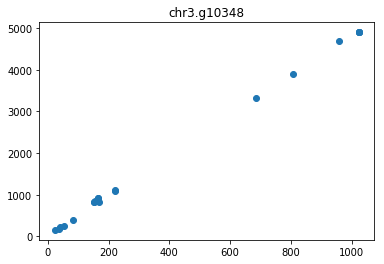

<Figure size 432x288 with 0 Axes>

In [69]:
count = 0
for geneID in allDict.keys():
    if 'chr3.g10348' not in geneID:
        continue
    if len(allDict[geneID]['alllengths']) < 4:
        continue
    count += 1
    plt.scatter(allDict[geneID]['allscores'],allDict[geneID]['alllengths'])
    plt.title('%s' % geneID)
    plt.show()
    plt.gcf().clear()
    
    if count > 15:
        break

## Generate output BED file with the non-redundant gene models

In [95]:
#Make BED file with just the transcript IDs that have the highest score
print(inDir)
outfile = inDir + 'HighestScoringTranscripts_IDs.bed'
outFile = open(outfile,'w')
print(outfile)

#Make directories
cmd = 'mkdir -p %s../ReducedGeneFiles_NoRedudant' % inDir
print(cmd)
runCMD(cmd)
#make outdir
outDir = '%s../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/' % inDir
cmd = 'mkdir -p %s' % outDir #conditionally make this output directory
print(cmd)
runCMD(cmd)

singleExonFile = open(outDir + 'singleExons_highestscoringtranscripts.bed','w')
nonSingleExonFile = open(outDir + '../multiExons_highestscoringtranscripts.bed','w')
nonSingleExonIDFile = open(outDir + '../multiExons_highestscoringtranscripts_IDs.txt','w')

missing=[]
added,singleExon = 0, 0
for key in scoreDict.keys():
    """if 'chr3.g10348' not in key:
        continue"""
    topHit = scoreDict[key]['fullID']
    if topHit not in fullDict.keys():
        missing.append(key)
        continue
    info = fullDict[topHit]
    
    for i in info:
        outFile.write('\t'.join(i) + '\n')
        added+=1
        exonCount = int(i[9])
        if exonCount == 1:
            singleExonFile.write('\t'.join(i) + '\n')
            singleExon += 1
        else:
            nonSingleExonFile.write('\t'.join(i) + '\n')
            nonSingleExonIDFile.write('%s\n' % i[3].split(';')[0].replace('ID=',''))
outFile.close()
singleExonFile.close()
nonSingleExonFile.close()
nonSingleExonIDFile.close()

#STATS
print('%i of the highest scoring genes added' % added)
print('\t%i of which are single exons' % singleExon)
print('Reduced from %i transcripts' % len(fullDict.keys()))
print('%i are missing' % len(missing))

/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/
/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/HighestScoringTranscripts_IDs.bed
mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant
mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/
59768 of the highest scoring genes added
	40560 of which are single exons
Reduced from 130960 transcripts
2109 are missing


In [96]:
missing[0:10]

['chr24.g12075',
 'chr34.g1204',
 'chr18.g16497',
 'chr15.g17075',
 'chr9.g16090',
 'chr16.g1716',
 'chr1.g4229',
 'chr2.g17917',
 'chr2.g13283',
 'chr13.g9982']

### Intersect the single exons with LINEs -- to eliminate those that correspond



In [97]:
outDir = '%s../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/' % inDir
singleExonFile = outDir + 'singleExons_highestscoringtranscripts.bed'
zoeyL1File = '/home/ampend/links/kidd-lab/genomes/zoey/assemblies/2.3/rm-tracks/zoey2.3.rmsk.LINE.bed'
zoeyLINESINELTRFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/transdecoder/ReducedGeneFiles_NoRedudant/zoey2.3.rmsk.LINE_SINE_LTR.bed'

#Write command to do intersect
cmd = 'bedtools intersect -wo -a %s -b %s > %sINTERSECT_singleExonsHighestScoring_with_ZoeyLINE_SINE_LTR.txt' % (singleExonFile,zoeyLINESINELTRFile,outDir)
print(cmd)
runCMD(cmd)


bedtools intersect -wo -a /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/singleExons_highestscoringtranscripts.bed -b /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/transdecoder/ReducedGeneFiles_NoRedudant/zoey2.3.rmsk.LINE_SINE_LTR.bed > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/INTERSECT_singleExonsHighestScoring_with_ZoeyLINE_SINE_LTR.txt


In [98]:
intersectFile = outDir + 'INTERSECT_singleExonsHighestScoring_with_ZoeyLINE_SINE_LTR.txt'
print('Parsing intersect file:\n',intersectFile)
intDict = {}

totalIntersectCount, noExonIntersectCount = 0, 0 #for keeping track 

for line in open(intersectFile,'r'):
    #FIRST SET INTERSECT == FALSE
    intersect = False
    totalIntersectCount += 1
    
    line = line.rstrip() #removing extraneous whitespace characters
    line = line.split('\t') #delimiting "columns" in the file based on tabs		
    winID = line[3]
    linelength = len(line)

    #Save gene info to dictionary if first time seeing it
    gene = line[3] #GENE
    geneStart, geneEnd = int(line[1]), int(line[2])
    exonStart, exonEnd = int(line[6]), int(line[7])
    lengthOfGene = geneEnd - geneStart
    lengthOfSingleExon = exonEnd - exonStart
    if gene not in intDict.keys():
        #0 = gene, #1 = length of gene, #2 = length of single exon
        #3 = all IDs of intersecting elements
        #4 = all lengths of intersecting elements
        #5 = all lengths of intersecting elements with EXONS only
        #6 = sum of all intersecting bp (set to zero)
        #7 = sum of all intersecting bp WITH EXONS only (set to zero)
        #8 = Prop of all GENE intersection (set to zero)
        #9 = proportion of all EXON intersection (sum of intersecting bp / length of single exon) (set to zero)
        #10 all the line information from the intersect file to use later to write out pass/fail exons
        #11 whether the gene passes/fails (determined in step below - default = Fail)
        intDict[gene] = [gene, lengthOfGene, lengthOfSingleExon, [], [], [], 0, 0, 0, 0, line[0:11], 'Fail']
     
    #DETERMINE IF RM ELEMENT INTERSECTS WITH EXON AT ALL
    RMstart = int(line[13])
    RMend = int(line[14])
    
    """ #Illustration of below intersect with Exon (E) and Repeat element (R)
    RRRRRRRRR
         EEEEEEEEEE
    """
    if RMstart <= exonStart and exonStart <= RMend and exonStart <= RMend:
        lengthOfIntersectWithExon = RMend - exonStart 
        intersect = True
    
    """ #Illustration of below intersect with Exon (E) and Repeat element (R)
    EEEEEEEEEE
        RRRRRRRRR
    """
    if exonStart <= RMstart and exonEnd <= RMend and RMstart <= exonEnd:
        lengthOfIntersectWithExon = exonEnd - RMstart  
        intersect = True
    
    """ #Illustration of below intersect with Exon (E) and Repeat element (R)
    EEEEEEEEEEEEEEEEEEEEE
           RRRRRRRRRR
    """
    if exonStart <= RMstart and exonEnd >= RMend:
        lengthOfIntersectWithExon = RMend - RMstart 
        intersect = True
    
    """ #Illustration of below intersect with Exon (E) and Repeat element (R)
    RRRRRRRRRRRRRRRRRRRRRRRRR
           EEEEEEEEEE
    """    
    if RMstart <= exonStart and RMend >= exonEnd:
        lengthOfIntersectWithExon = exonEnd - exonStart 
        intersect = True
    
    #Only want to add up the intersecting data for RMs intersecting EXONS
    if intersect is False:
        noExonIntersectCount+=1
        lengthOfIntersectWithExon = 0
        #continue
    
    intersectingElement = str(line[linelength-14])
    lengthOfGeneIntersect = int(line[linelength-1]) #WITH WHOLE GENE

    
    #propOfGeneIntersecting = float(lengthOfIntersect/lengthOfGene)
    propOfGeneIntersecting = float(lengthOfIntersectWithExon/lengthOfSingleExon)
    
    #Add info to dictionary
    intDict[gene][3].append(intersectingElement)
    intDict[gene][4].append(lengthOfGeneIntersect)
    intDict[gene][5].append(lengthOfIntersectWithExon)
print('%i of the %i total intersects do not intersect with the exons' % (noExonIntersectCount,totalIntersectCount))



Parsing intersect file:
 /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/INTERSECT_singleExonsHighestScoring_with_ZoeyLINE_SINE_LTR.txt
27067 of the 45859 total intersects do not intersect with the exons


### Now go through each threshold of intersect proportion of alignment and generate outfiles for the transcripts that pass/fail at each threshold

In [99]:
#INTERSECT THRESHOLD
thresholds = [0.0001, 0.05, 0.1, 0.3333, 0.5, 0.6666, 0.75]
#threshold = 0.5

for threshold in thresholds:
    passIDs, failIDs = [], []
    passFile = open(outDir + 'SingleExon_PassRMIntersect_%fthreshold.txt' % threshold,'w')
    failFile = open(outDir + 'SingleExon_FailRMIntersect_%fthreshold.txt' % threshold,'w')
    count = 0

    for gene in intDict.keys():
        #Calculate how much of exon is covered by RMs
        GENEintersectSum = np.sum(intDict[gene][4])
        EXONintersectSum = np.sum(intDict[gene][5])
        intDict[gene][6] = GENEintersectSum
        intDict[gene][7] = EXONintersectSum
        #Now calculate what this sum is as a proportion of the exon length
        propOfExonIntersecting = float(EXONintersectSum/intDict[gene][2])
        intDict[gene][9] = propOfExonIntersecting
        #What would this be compared to with proportion of gene covered?
        propOfGeneIntersecting = float(GENEintersectSum/intDict[gene][1])
        intDict[gene][8] = propOfGeneIntersecting

        if propOfGeneIntersecting < 0.5 and propOfExonIntersecting > 0.5:
            count +=1
            coord = intDict[gene][10][0]+':'+str(intDict[gene][10][1])+'-'+str(intDict[gene][10][2])
            """print(coord)
            print(gene)
            print('gene length', intDict[gene][1])
            print('exon length', intDict[gene][2])
            print('gene intersect sum',GENEintersectSum)
            print('exon intersect sum',EXONintersectSum)
            print(propOfGeneIntersecting,propOfExonIntersecting,'\n')"""

        #Check if greater than threshold
        if propOfExonIntersecting < threshold:
            passFile.write('\t'.join(intDict[gene][10]) + '\n')
            passIDs.append(gene)
            intDict[gene][11] = 'Pass'
        else:
            failIDs.append(gene)
            failFile.write('\t'.join(intDict[gene][10]) + '\n')
    passFile.close()
    failFile.close()
    
    print('## Threshold = %f' % threshold)
    print('%i of the %i single exon genes intersect LINEs/SINEs/LTRs with more than %f of their length' % (len(set(failIDs)),singleExon,threshold))
    print('%i of the %i single exon genes PASS intersect thresholds\n' % (len(set(passIDs)),singleExon))


## Threshold = 0.000100
15760 of the 40560 single exon genes intersect LINEs/SINEs/LTRs with more than 0.000100 of their length
7621 of the 40560 single exon genes PASS intersect thresholds

## Threshold = 0.050000
15014 of the 40560 single exon genes intersect LINEs/SINEs/LTRs with more than 0.050000 of their length
8367 of the 40560 single exon genes PASS intersect thresholds

## Threshold = 0.100000
14325 of the 40560 single exon genes intersect LINEs/SINEs/LTRs with more than 0.100000 of their length
9056 of the 40560 single exon genes PASS intersect thresholds

## Threshold = 0.333300
11276 of the 40560 single exon genes intersect LINEs/SINEs/LTRs with more than 0.333300 of their length
12105 of the 40560 single exon genes PASS intersect thresholds

## Threshold = 0.500000
9592 of the 40560 single exon genes intersect LINEs/SINEs/LTRs with more than 0.500000 of their length
13789 of the 40560 single exon genes PASS intersect thresholds

## Threshold = 0.666600
8450 of the 40560 si

### Now generate two FASTA files for the threshold you want to go with that contains 1) those transcripts that PASS at that cutoff 2) those transcripts that FAIL at that cutoff

#### Make ID list of only those single exon genes that pass at cutoff

In [100]:
threshold = 0.1 #******

inFile = outDir + 'SingleExon_PassRMIntersect_%fthreshold.txt' % threshold
outFile = outDir + 'SingleExon_PassRMIntersect_%fthreshold_IDs.txt' % threshold

cmd = 'cut -f 4 %s > %s' % (inFile,outFile)
print(cmd)
runCMD(cmd)

lineCount = count_lines(outFile)
print('\n%i single exons pass this cutoff and had their IDs written out' % lineCount)

cut -f 4 /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/SingleExon_PassRMIntersect_0.100000threshold.txt > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/SingleExon_PassRMIntersect_0.100000threshold_IDs.txt

9056 single exons pass this cutoff and had their IDs written out


In [101]:
#INTERSECT THRESHOLD
threshold = 0.1 #*******

passfileIDs = outDir + 'SingleExon_PassRMIntersect_%fthreshold_IDs.txt' % threshold
passFileIDs = open(passfileIDs, 'w')
count = 0

failfileIDs = outDir + 'SingleExon_FailRMIntersect_%fthreshold_IDs.txt' % threshold
failFileIDs = open(failfileIDs, 'w')

for gene in intDict.keys():
    ID = gene.split(';')[0] #TO MATCH THE FASTA FILE WE WANT TO EXTRACT FROM

    #Calculate how much of exon is covered by RMs
    GENEintersectSum = np.sum(intDict[gene][4])
    EXONintersectSum = np.sum(intDict[gene][5])
    intDict[gene][6] = GENEintersectSum
    intDict[gene][7] = EXONintersectSum
    #Now calculate what this sum is as a proportion of the exon length
    propOfExonIntersecting = float(EXONintersectSum/intDict[gene][2])
    intDict[gene][9] = propOfExonIntersecting
    #What would this be compared to with proportion of gene covered?
    propOfGeneIntersecting = float(GENEintersectSum/intDict[gene][1])
    intDict[gene][8] = propOfGeneIntersecting

    #Check if greater than threshold
    if propOfExonIntersecting < threshold:
        passFileIDs.write('%s\n' % ID.replace('ID=',''))
        count+=1        
    else:
        failFileIDs.write('%s\n' % ID.replace('ID=',''))
passFileIDs.close()
failFileIDs.close()
print('Wrote out IDs for %i passing single exon transcripts' % count)

### Copy to new directory for only the passing genes
nonRedundDir = baseDir + 'NonRedundant_NoRMIntersect_FilteredGeneSet/'
cmd = 'mkdir -p %s' % nonRedundDir #conditionally make output directory
print(cmd)
runCMD(cmd)


print('#Copying to new directory')
cmd = 'cp %s %s' % (passfileIDs,nonRedundDir)
runCMD(cmd)
print(cmd)


Wrote out IDs for 9056 passing single exon transcripts
mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/
#Copying to new directory
cp /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/SingleExon_PassRMIntersect_0.100000threshold_IDs.txt /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/


#### Copying the multi exon file to same directory

In [102]:
print('#Copying to new directory')
multiExon = outDir + '../multiExons_highestscoringtranscripts_IDs.txt'

cmd = 'cp %s %s' % (multiExon,nonRedundDir)
runCMD(cmd)
print(cmd)



#Copying to new directory
cp /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/../multiExons_highestscoringtranscripts_IDs.txt /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/


### Now need to get all the transcript IDs (multi and single exon) genes that pass the cut off --- can use FGREP from the total highest scoring transcript file to get the file transcript list, using the *FAILING* genes as what to fgrep -v (all but == -v)

In [103]:
#Use fgrep to get the all IDs that are NOT in the failing RM threshold file

cmd = 'fgrep -v -f %sSingleExon_FailRMIntersect_%fthreshold_IDs.txt %sHighestScoringTranscripts_IDs.bed | cut -f 4 | sed \'s/ID=//\' > %stemp_IDs.txt' % (outDir,threshold,inDir,nonRedundDir)
print(cmd)
runCMD(cmd)

temp_IDfile = nonRedundDir + 'temp_IDs.txt'
IDfile = open(nonRedundDir + 'TotalSet_NoRMSingleExons_AllMultiExons_IDs.txt','w')
for line in open(temp_IDfile,'r'):
    line=line.rstrip()
    ID = line.split(';')[0]
    IDfile.write('%s\n' % ID)
IDfile.close()

lineCount = count_lines('%sTotalSet_NoRMSingleExons_AllMultiExons_IDs.txt' % nonRedundDir)
print('%i total genes remain after eliminating single exons with too much RM' % lineCount)

#Get BED coordinates from transdecoder file
DIR = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/'
fullBed = DIR + 'pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.genome.bed' #all transdecoder bed coordinates
cmd = 'fgrep -f %s %s | sort | uniq > %sTotalSet_NoRMSingleExons_AllMultiExons.bed' % (temp_IDfile, fullBed, nonRedundDir) 
print(cmd)
runCMD(cmd)

#remove temp file
cmd = 'rm %s' % temp_IDfile
runCMD(cmd)

fgrep -v -f /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/../ReducedGeneFiles_NoRedudant/IntersectWithRepeatElements/SingleExon_FailRMIntersect_0.100000threshold_IDs.txt /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/HighestScoringTranscripts_IDs.bed | cut -f 4 | sed 's/ID=//' > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/temp_IDs.txt
45443 total genes remain after eliminating single exons with too much RM
fgrep -f /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/temp_IDs.txt /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.genome.bed | sort | uniq > /home

## Index the total fasta file from transdecoder so you can extract by ID

In [104]:
pepFasta = inDir + 'pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.pep'
cdsFasta = inDir + 'pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.cds'

#indexing the peptide fasta file
cmd = 'samtools faidx %s' % pepFasta
runCMD(cmd)
print(cmd)

#indexing the CDS fasta file
cmd = 'samtools faidx %s' % cdsFasta
runCMD(cmd)
print(cmd)

samtools faidx /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.pep
samtools faidx /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.cds


### Getting the FASTA 

In [105]:
#using the ID file generated above to extract from the fasta file
#__Example Usage__
# xargs samtools faidx test.fa < names.txt

##PEPTIDE FASTA
IDFile = nonRedundDir + 'TotalSet_NoRMSingleExons_AllMultiExons_IDs.txt'
outFasta = IDFile.replace('_IDs.txt','_pep.fa')

cmd = 'xargs samtools faidx %s < %s > %s' % (pepFasta,IDFile,outFasta)
print(cmd)
runCMD(cmd)

cmd = 'samtools faidx %s' % outFasta
print(cmd)
runCMD(cmd)

##CDS FASTA
outFasta = IDFile.replace('_IDs.txt','_cds.fa')

cmd = 'xargs samtools faidx %s < %s > %s' % (cdsFasta,IDFile,outFasta)
print(cmd)
runCMD(cmd)

cmd = 'samtools faidx %s' % outFasta
print(cmd)
runCMD(cmd)

xargs samtools faidx /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.pep < /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_IDs.txt > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_pep.fa
samtools faidx /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_pep.fa
xargs samtools faidx /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.cds < /home/ampend/links/kidd-lab/amp

In [66]:
nonRedundDir

'/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/'

## How many genes are there in the final set?

In [89]:
lineCount = count_lines(IDFile)
print('%i transcripts in the final, nonredundant, nonRM transcript set' % lineCount)

45443 transcripts in the final, nonredundant, nonRM transcript set


# Make bed file of the final gene models

In [ ]:
cmd = 'fgrep -f '